In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib as mpl
from salishsea_tools import viz_tools, geo_tools,nc_tools
from scipy.interpolate import griddata, interp1d
import matplotlib.cm as cm
import xarray as xr

In [2]:
path = '/home/ssahu/saurav/JP_BC/'
gridT = xr.open_dataset(path+'cat_42_days_T.nc')

In [3]:
gridT.coords

Coordinates:
  * deptht        (deptht) float32 0.494025 1.54138 2.64567 3.81949 5.07822 ...
  * time_counter  (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * bnds          (bnds) int64 0 1

In [4]:
gridT.dims

Frozen(SortedKeysDict({'y': 1021, 'bnds': 2, 'time_counter': 43, 'deptht': 50, 'x': 715}))

In [5]:
gridT.attrs

OrderedDict([('Conventions', 'CF-1.1'),
             ('CDI',
              'Climate Data Interface version 1.7.1 (http://mpimet.mpg.de/cdi)'),
             ('history',
              'Wed Jul 27 13:01:08 2016: /usr/local/bin/ncrename -O -v lat,nav_lat -v lon,nav_lon /fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/CDF_COMB/NEP036-N30_IN_20160401_00813600_grid_T.nc\nWed Jul 27 12:36:59 2016: cdo timmean /fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/DIMG/NEP036-N30_CU60_20160401_20160332_00813600_grid_T_0000.nc /fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/WORKDIR_grid_T_00813600/timmean_grid_T_00813600_0000.nc'),
             ('file_name',
              '/fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/CDF_COMB/NEP036-N30_IN_20160401_00813600_grid_T.nc'),
             ('production', 'An IPSL model'),
             ('TimeStamp', '2016-JUL-27 10:02:26 GMT-0000'),
             ('CDO',
              'Climate Data Operators version 1.7.1 (http://mpimet.mpg.de/cdo)')])

In [6]:
gridT.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, deptht: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * deptht             (deptht) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.283 -142.256 -142.228 -142.2 ...
    nav_lat            (y, x) float32 45.0491 45.0479 45.0467 45.0456 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    votemper           (time_counter, deptht, y, x) float64 0.0 8.881 8.905 ...
    vosaline           (time_counter, deptht, y, x) float64 0.0 33.14 33.13 ...
    sosstsst           (time_counter, y, x) float64 0.0 8.881 8.905 8.925 ...
    sosaline           (

In [7]:
ssh = np.array(gridT['sossheig'][:,55:400,446:701]);
votemper = np.array(gridT['votemper'][:,:,55:400,446:701]);
vosaline = np.array(gridT['vosaline'][:,:,55:400,446:701])
glamt_bc_JP = np.array(gridT['nav_lon'][55:400,446:701]);
gphit_bc_JP = np.array(gridT['nav_lat'][55:400,446:701]);


In [8]:
fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

In [9]:
with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...]; 

In [10]:
votemper.shape

(43, 50, 345, 255)

In [11]:
glamt_bc_JP.shape

(345, 255)

In [12]:
np.min(gphit_wcvi)

46.113550613066906

In [13]:
np.min(np.array(gphit_bc_JP))

45.213524

In [14]:
(Nx,Ny) = gphit_wcvi.shape

In [15]:
X = glamt_bc_JP.flatten()

Y = gphit_bc_JP.flatten()

points = (X[:],Y[:])

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

#Number of points to trim off the ends

N = 5

glamt_wcvi_bc_left = glamt_wcvi[:,0:N-1]; gphit_wcvi_bc_left = gphit_wcvi[:,0:N-1];
glamt_wcvi_bc_right = glamt_wcvi[:,-N:-1]; gphit_wcvi_bc_right = gphit_wcvi[:,-N:-1];


xi_left = (glamt_wcvi_bc_left.flatten(), gphit_wcvi_bc_left.flatten());
xi_right = (glamt_wcvi_bc_right.flatten(), gphit_wcvi_bc_right.flatten());

#votemper_wcvi = np.zeros((43,50,Nx,Ny));

votemper_wcvi_left = np.zeros((43,50,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));
votemper_wcvi_right = np.zeros((43,50,glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]));

ssh_wcvi_left = np.zeros((43,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));


for p,q in enumerate(votemper_wcvi_left[:,...]):
    for i,j in enumerate(votemper_wcvi_left[p,:,...]):
        votemper_wcvi_left[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_left, method= 'linear'), glamt_wcvi_bc_left.shape)
        votemper_wcvi_right[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_right, method= 'linear'), glamt_wcvi_bc_right.shape)
#        vosaline_wcvi[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi, method= 'linear', glamt_wcvi.shape))

#vosaline_wcvi = np.reshape(griddata(points, vosaline.flatten(), xi, method= 'linear'), glamt_wcvi.shape)

In [17]:
votemper_wcvi_left.shape

(43, 50, 100, 4)

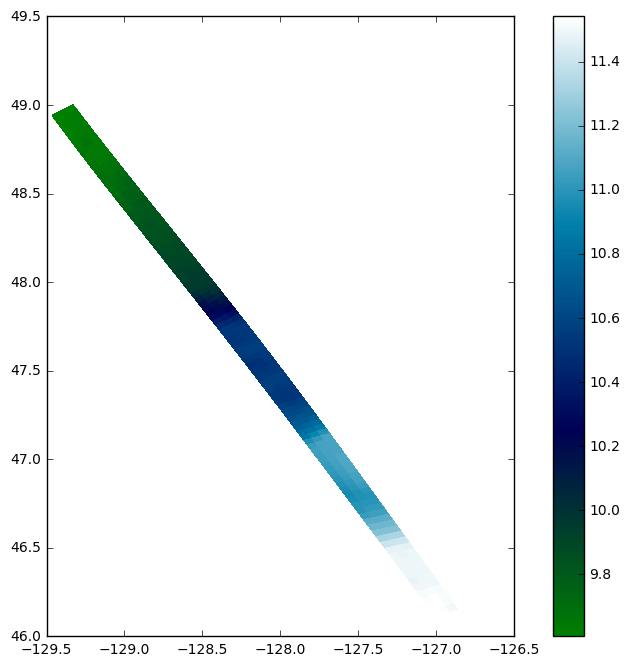

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],votemper_wcvi_left[0,0,:], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

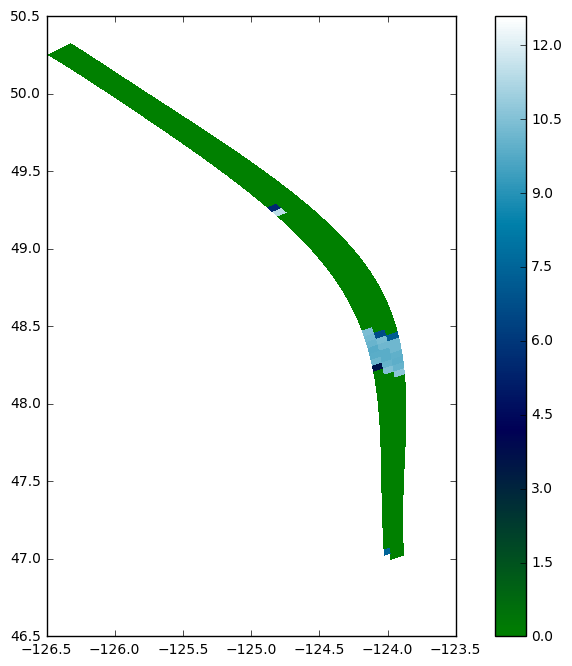

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_right[:], gphit_wcvi_bc_right[:],votemper_wcvi_right[0,0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

In [28]:
np.save('votemper_leftbc', votemper_wcvi_left)

In [29]:
np.save('votemper_rightbc', votemper_wcvi_right)

In [ ]:
#Now for Salinity


#votemper_wcvi = np.zeros((43,50,Nx,Ny));

vosaline_wcvi_left = np.zeros((43,50,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));
vosaline_wcvi_right = np.zeros((43,50,glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]));



for p,q in enumerate(vosaline_wcvi_left[:,...]):
    for i,j in enumerate(vosaline_wcvi_left[p,:,...]):
        vosaline_wcvi_left[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_left, method= 'linear'), glamt_wcvi_bc_left.shape)
        vosaline_wcvi_right[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_right, method= 'linear'), glamt_wcvi_bc_right.shape)



In [137]:
ssh_wcvi = np.zeros((43,Nx,Ny))
for i,j in enumerate(ssh[:,...]):
    ssh_wcvi[i,...] = np.reshape(griddata(points, ssh[i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)

KeyboardInterrupt: 

In [126]:
votemper_wcvi.shape

(43, 50, 100, 70)

In [128]:
glamt_wcvi.shape

(100, 70)

In [149]:
#Number of points to trim off the ends

N = 5

glamt_wcvi_bc_left = glamt_wcvi[:,0:N-1]; gphit_wcvi_bc_left = gphit_wcvi[:,0:N-1];

glamt_wcvi_bc_right = glamt_wcvi[:,-N:-1]; gphit_wcvi_bc_right = gphit_wcvi[:,-N:-1];

xi = (glamt_wcvi_bc_left.flatten(), gphit_wcvi_bc_left.flatten())

ssh_wcvi_left = np.zeros((43,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]))

for i,j in enumerate(ssh_wcvi_left[:,...]):
    ssh_wcvi_left[i,...] = np.reshape(griddata(points, np.array(ssh[i,...]).flatten(), xi, method= 'linear'), glamt_wcvi_bc_left.shape)

print(glamt_wcvi_bc_right.shape, ssh_wcvi_left.shape)

(100, 4) (43, 100, 4)


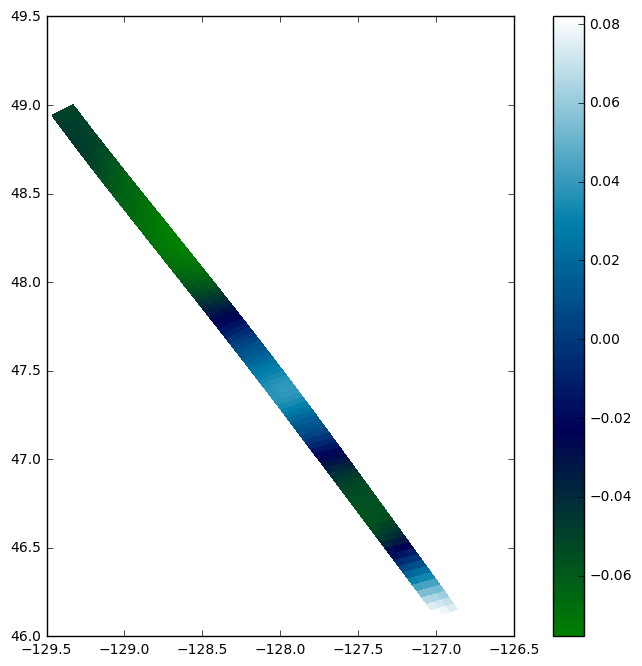

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],ssh_wcvi_left[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

#### Next we would like to interpolate the values of JP to the outer say 5 grid point cells of our domain based on  matching the lats and lons of JP with our domain

In [120]:
for idx, val in enumerate(votemper_wcvi[0,:,...]):
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [14]:
np.array(ssh)

array([[[  0.00000000e+00,  -1.86861958e-02,  -1.34836314e-02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -1.86861958e-02,  -1.86861958e-02,  -1.34836314e-02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -1.86894257e-02,  -1.86894257e-02,  -2.90848408e-02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00]],

       [[  0.00000000e+00,   6.79792762e-02,   7.52824321e-02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  6.79792762e-02,   6.79792762e-02,   7.52824321e-0

In [16]:
ssh.shape

(43, 1021, 715)

#### Remaining work
    1) Interpolate to our WCVI grid points of T, S and SSH first 
     2) Slice our domain to keep those variables only for the boundary points (strip of 5 data points on the outer boundary)
     3) Use the filter on the surface T and S points after having sliced them
     4) Do the rotation thingy on U and V points only for the stripped domain (get glamu and gphiu for wcvi and have them on those points
     5) Write a boundary condition file (4 Files one for each boundary) (2D and 3D separately)

In [ ]:
votemper, vosaline, nav_lon, nav_lat, time_counter_bnds, sossheig